# Description

This notebook consists of Facial Recognition with the following distinct approaches:

*   Part 1: Raw CNN model training and testing for multi-class classification
*   Part 2: FaceNet with Nearest Neighbors



# Part 1: Raw CNN

### Labelled Faces in the Wild (LFW) data exploration - distribution of dataset across distinct persons, general face detection using MTCNN, prepare image paths.

In [1]:
pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.3 MB/s 


In [2]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict

# For CNN and FFNN
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import keras
from sklearn.model_selection import train_test_split

# for visualization
from PIL import Image

# for face detection
from mtcnn.mtcnn import MTCNN

# for bounding boxes
import matplotlib.patches as patches

# for moving/copying files
import shutil
from shutil import unpack_archive
from subprocess import check_output

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!ls "/content/drive/My Drive/CMPE-258-Deep-Learning/lfw"

face_dataset	       matchpairsDevTrain.csv	  peopleDevTest.csv
face_queryset	       mismatchpairsDevTest.csv   peopleDevTrain.csv
lfw_allnames.csv       mismatchpairsDevTrain.csv  sample_face_dataset
lfw-deepfunneled       model			  sample_face_queryset
lfw_readme.csv	       pairs.csv		  working
matchpairsDevTest.csv  people.csv


In [5]:
dataset_path = "/content/drive/My Drive/CMPE-258-Deep-Learning/lfw/"

In [6]:
lfw_allnames = pd.read_csv(dataset_path + "lfw_allnames.csv")
lfw_allnames

,name,images
0,AJ_Cook,1
1,AJ_Lamas,1
2,Aaron_Eckhart,1
3,Aaron_Guiel,1
4,Aaron_Patterson,1
...,...,...
5744,Zorica_Radovic,1
5745,Zulfiqar_Ahmed,1
5746,Zumrati_Juma,1
5747,Zurab_Tsereteli,1


In [7]:
# Stats about the LFW image dataset
lfw_allnames.describe()

,images
count,5749.000000
mean,2.301792
std,9.016410
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,530.000000


In [8]:
lfw_allnames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5749 entries, 0 to 5748
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5749 non-null   object
 1   images  5749 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.0+ KB


In [9]:
# Display top N persons with images
lfw_allnames.sort_values(by=['images'], ascending=False).head(20)

,name,images
1871,George_W_Bush,530
1047,Colin_Powell,236
5458,Tony_Blair,144
1404,Donald_Rumsfeld,121
1892,Gerhard_Schroeder,109
373,Ariel_Sharon,77
2175,Hugo_Chavez,71
2941,Junichiro_Koizumi,60
2468,Jean_Chretien,55
2682,John_Ashcroft,53


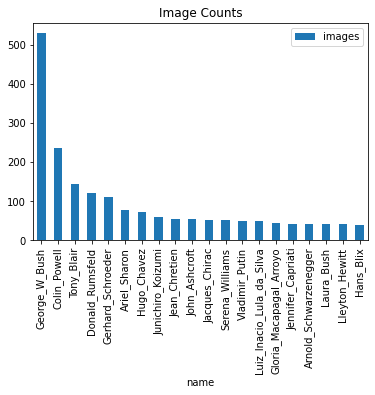

In [10]:
# Plot the image count distribution
lfw_allnames.sort_values(by=['images'], ascending=False).head(20).plot(x='name', title='Image Counts', kind = 'bar')

In [11]:
# Determine how many entries have only 1 image per name.
single_img_count = sum(lfw_allnames.loc[lfw_allnames['images'] == 1]['images'])
total_img_count = sum(lfw_allnames['images'])
print('single_img_count: {}'.format(single_img_count))
print('total_img_count: {}'.format(total_img_count))
print('% of images with only 1 image per person: {:.2f} %'.format(single_img_count / total_img_count * 100))

single_img_count: 4069
total_img_count: 13233
% of images with only 1 image per person: 30.75 %


In [12]:
lfw_allnames['name']

0                  AJ_Cook
1                 AJ_Lamas
2            Aaron_Eckhart
3              Aaron_Guiel
4          Aaron_Patterson
               ...        
5744        Zorica_Radovic
5745        Zulfiqar_Ahmed
5746          Zumrati_Juma
5747       Zurab_Tsereteli
5748    Zydrunas_Ilgauskas
Name: name, Length: 5749, dtype: object

In [13]:
def generate_image_paths(lfw_allnames):

  # Create new dataframe where each name is repeated for the number of images indicated for them.
  # E.g. Since Zhu_Rongji has 9 images, so it would repeat it 9 times into image_paths df.
  image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]

  # Since we want each image to be designated starting at 1, e.g.:
  #    Zhu_Rongji_0001.jpg
  #    Zhu_Rongji_0002.jpg
  #    ...
  #    Zhu_Rongji_0009.jpg

  # Enumerate each image_path for a given person, starting from 1.
  image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()

  # Pad zeroes into each of the image_path values, e.g. 1 -> 0001.
  image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))

  # Create the full relative path that can be used to lookup the actual images.
  # E.g. Zhu_Rongji => Zhu_Rongji/Zhu_Rongji_0001.jpg
  image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"

  # Drop the 'images' column since image_path column is now there.
  image_paths = image_paths.drop("images", axis=1)

  return image_paths

In [14]:
image_paths = generate_image_paths(lfw_allnames)
image_paths

,name,image_path
0,AJ_Cook,AJ_Cook/AJ_Cook_0001.jpg
1,AJ_Lamas,AJ_Lamas/AJ_Lamas_0001.jpg
2,Aaron_Eckhart,Aaron_Eckhart/Aaron_Eckhart_0001.jpg
3,Aaron_Guiel,Aaron_Guiel/Aaron_Guiel_0001.jpg
4,Aaron_Patterson,Aaron_Patterson/Aaron_Patterson_0001.jpg
...,...,...
5744,Zorica_Radovic,Zorica_Radovic/Zorica_Radovic_0001.jpg
5745,Zulfiqar_Ahmed,Zulfiqar_Ahmed/Zulfiqar_Ahmed_0001.jpg
5746,Zumrati_Juma,Zumrati_Juma/Zumrati_Juma_0001.jpg
5747,Zurab_Tsereteli,Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg


In [15]:
# Make a copy for further exploration.
df = image_paths.copy()
df = df.reset_index().drop('index', axis=1)

# Verifying George_W_Bush images with their corresponding paths.
df.loc[df['name'] == 'George_W_Bush']

,name,image_path
3948,George_W_Bush,George_W_Bush/George_W_Bush_0001.jpg
3949,George_W_Bush,George_W_Bush/George_W_Bush_0002.jpg
3950,George_W_Bush,George_W_Bush/George_W_Bush_0003.jpg
3951,George_W_Bush,George_W_Bush/George_W_Bush_0004.jpg
3952,George_W_Bush,George_W_Bush/George_W_Bush_0005.jpg
...,...,...
4473,George_W_Bush,George_W_Bush/George_W_Bush_0526.jpg
4474,George_W_Bush,George_W_Bush/George_W_Bush_0527.jpg
4475,George_W_Bush,George_W_Bush/George_W_Bush_0528.jpg
4476,George_W_Bush,George_W_Bush/George_W_Bush_0529.jpg


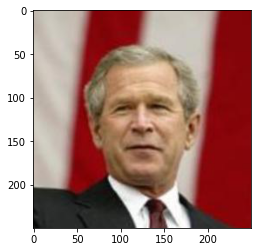

In [16]:
# Show a sample image to verify it.
basepath = dataset_path + 'lfw-deepfunneled/'
test_image_path = df.image_path[4473]
img = Image.open(basepath + str(test_image_path))
plt.imshow(img)

In [17]:
def detect_face_MTCNN(image_path):
  detector = MTCNN()
  img = cv2.imread(basepath + str(image_path))
  result = detector.detect_faces(img)
  bounding_box = result[0]['box']
  keypoints = result[0]['keypoints']

  # Plot the image along with the detected bounding box and keypoints.
  fig, ax = plt.subplots()
  ax.imshow(img)

  # Superimpose the bounding box.
  bbox = patches.Rectangle(bounding_box[0:2], bounding_box[2], bounding_box[3], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(bbox)

  # Superimpose the keypoints.
  for key in keypoints:
    kp = patches.Rectangle(keypoints[key], 1, 1, linewidth=10, edgecolor='r', facecolor='none')
    ax.add_patch(kp)

  plt.show()

1/1 [==============================] - 0s 139ms/step


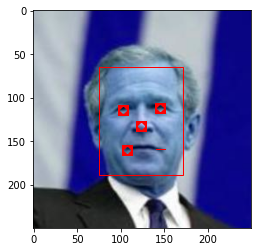

In [18]:
# Test face detection with MTCNN for the above image.
detect_face_MTCNN(test_image_path)

### Additional insights into dataset distribution, verification of consistent resolution.

In [ ]:
from PIL import Image


In [ ]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = dataset_path+"/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

all 250 x 250 resolution

In [ ]:
ImageCounts = pd.DataFrame(list(lfw_allnames['images'].value_counts().to_dict().items()),columns=['Count of Images','Num of People']).head(30)
#ImageCounts=ImageCounts.rename(columns={" ": "count", "images": "People"}, errors="raise")
print(ImageCounts)


    Count of Images  Num of People
0                 1           4069
1                 2            779
2                 3            291
3                 4            187
4                 5            112
5                 6             55
6                 7             39
7                 8             33
8                 9             26
9                11             16
10               10             15
11               13             11
12               15             11
13               12             10
14               14             10
15               17              8
16               19              7
17               20              5
18               22              5
19               18              5
20               21              4
21               33              3
22               16              3
23               32              3
24               24              3
25               23              3
26               29              2
27               31 

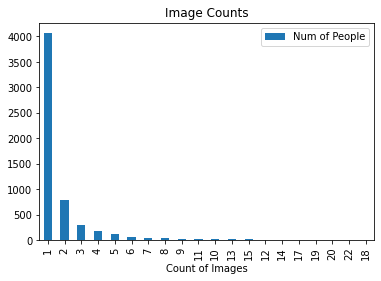

In [ ]:
ImageCounts.head(20).plot(x='Count of Images', y='Num of People',title='Image Counts', kind = 'bar')

## LFW Training

### Data Preparation - take the top 6 persons with the most images, generate separate working directories for training, validation, and testing datasets, subsetted per person.

In [19]:
# find the top N most common images in the dataset
image_paths['name'].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

In [20]:
# balance samples across the above top N
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])
multi_data['name'].value_counts()

George_W_Bush        75
Colin_Powell         75
Tony_Blair           75
Donald_Rumsfeld      75
Gerhard_Schroeder    75
Ariel_Sharon         75
Name: name, dtype: int64

In [21]:
# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split training data into validation data
multi_train, multi_val = train_test_split(multi_train, test_size=0.2)

In [22]:
multi_train.shape

(288, 2)

In [23]:
multi_val.shape

(72, 2)

In [24]:
multi_test.shape

(90, 2)

In [25]:
# Declaring the location of the working directory for processing
dest_dir = dataset_path + 'working/'

# A convenience function for copying images into working sub-directories
def directory_copier(data, dir_name):
    count = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join(dest_dir, dir_name)):
            shutil.os.mkdir(os.path.join(dest_dir, dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join(dest_dir, dir_name, data_type)):
            shutil.os.mkdir(os.path.join(dest_dir, dir_name, data_type))
        path_from = os.path.join(basepath, image)
        path_to = os.path.join(dest_dir, dir_name, data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Copied {} to {}'.format(image,path_to))
        count += 1
        
    print('Copied {} images to {} folder.'.format(count, dir_name))

In [ ]:
# place training images into its respective working directory
directory_copier(multi_train, "train_multi/")

Copied 288 images to train_multi/ folder.


In [ ]:
# same for these, move into their respective working directories
directory_copier(multi_val, "val_multi/")
directory_copier(multi_test, "test_multi/")

Copied 72 images to val_multi/ folder.
Copied 90 images to test_multi/ folder.


In [26]:
workdir = dataset_path + 'working/'
workdir

'/content/drive/My Drive/CMPE-258-Deep-Learning/lfw/working/'

In [27]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)


multi_training_set = train_datagen.flow_from_directory(workdir + 'train_multi/',
                                                       target_size = (250, 250),
                                                       batch_size = 32,
                                                       class_mode = 'categorical')

multi_val_set = test_datagen.flow_from_directory(workdir + 'val_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

multi_test_set = test_datagen.flow_from_directory(workdir + 'test_multi/',
                                                  target_size = (250, 250),
                                                  batch_size = 32,
                                                  class_mode = 'categorical')

Found 288 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


### Training - CNN with 3x3 kernel, 2x2 Max-Pooling, flattened into a FFNN with multi-class classifier output for 6 possible outcomes.

In [ ]:
multi_classifier = Sequential()

# use a 3x3 kernel for convolution, input is 250x250x3 with 3-channel because color image
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# pooling to reduce dimension of convolution layers output
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))

multi_classifier.add(Conv2D(64, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2, 2)))

multi_classifier.add(Flatten())

# feed flattened output into a fully-connected layer
multi_classifier.add(Dense(units = 128, activation = 'relu'))

# final output classifies as one of up to 6 possibilities.
multi_classifier.add(Dense(units = 6, activation = 'softmax'))

# compile the model
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
multi_classifier.output_shape

(None, 6)

In [ ]:
multi_history = multi_classifier.fit_generator(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               #steps_per_epoch = 288,
                                               # as the data is smaller, we can run for more epochs
                                               epochs = 30,
                                               validation_data = multi_val_set
                                               #,validation_steps = 72
                                               )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
9/9 [==============================] - 35s 4s/step - loss: 7.4855 - accuracy: 0.1389 - val_loss: 1.8742 - val_accuracy: 0.2361
Epoch 2/30
9/9 [==============================] - 32s 4s/step - loss: 1.8307 - accuracy: 0.2361 - val_loss: 1.7895 - val_accuracy: 0.2639
Epoch 3/30
9/9 [==============================] - 35s 4s/step - loss: 1.7763 - accuracy: 0.2257 - val_loss: 1.7714 - val_accuracy: 0.2639
Epoch 4/30
9/9 [==============================] - 34s 4s/step - loss: 1.7384 - accuracy: 0.2778 - val_loss: 1.7245 - val_accuracy: 0.2500
Epoch 5/30
9/9 [==============================] - 32s 3s/step - loss: 1.6608 - accuracy: 0.3194 - val_loss: 1.7422 - val_accuracy: 0.3194
Epoch 6/30
9/9 [==============================] - 34s 3s/step - loss: 1.6067 - accuracy: 0.3819 - val_loss: 1.6713 - val_accuracy: 0.2917
Epoch 7/30
9/9 [==============================] - 34s 4s/step - loss: 1.5685 - accuracy: 0.3819 - val_loss: 1.6173 - val_accuracy: 0.3194
Epoch 8/30
9/9 [==================

### Assess training accuracy and model loss performance - generally increasing accuracy with successive epoch iteration, with divergence from validation after about 26 epochs.

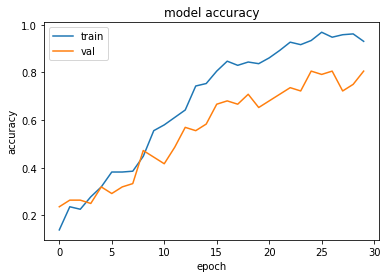

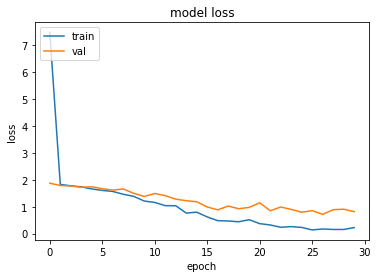

In [ ]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## LFW Validation

### Generate predictions for the test dataset.

In [ ]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name, classifier, binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = load_img(dir_name + str(im), target_size = (250,250))
        test_image = img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

In [ ]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
multi_test_names = []

# collect all file names
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])

# extract unique names, in order
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]

multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))
print(f'multi_test_name_order: {multi_test_name_order}')

# Generate predictions
multi_predictions_0 = predictions(workdir + 'test_multi/' + multi_test_name_order[0] + "/", multi_classifier, binary=False)
multi_predictions_1 = predictions(workdir + 'test_multi/' + multi_test_name_order[1] + "/", multi_classifier, binary=False)
multi_predictions_2 = predictions(workdir + 'test_multi/' + multi_test_name_order[2] + "/", multi_classifier, binary=False)
multi_predictions_3 = predictions(workdir + 'test_multi/' + multi_test_name_order[3] + "/", multi_classifier, binary=False)
multi_predictions_4 = predictions(workdir + 'test_multi/' + multi_test_name_order[4] + "/", multi_classifier, binary=False)
multi_predictions_5 = predictions(workdir + 'test_multi/' + multi_test_name_order[5] + "/", multi_classifier, binary=False)

multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predictions','Actual'])

multi_test_name_order: ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']
1/1 [==============================] - 0s 58ms/step


In [ ]:
multi_predictions_frame.shape

(90, 2)

In [ ]:
# Set of possible values for predictions
set(multi_predictions_frame.Predictions)

{0, 1, 2, 3, 4, 5}

In [ ]:
# Set of possible values for actuals
set(multi_predictions_frame.Actual)

{0, 1, 2, 3, 4, 5}

### Assess precision and recall performance for the test dataset, per class (person). Performance is generally low, and has room for further improvement, perhaps through tuning and additional layers of convolution and pooling.

In [ ]:
# Overall Accuracy, Precision & Recall performance
perf = prec_acc(multi_predictions_frame)
print('Accuracy:' + str(np.round(perf[0], 2)))
print('Precision:' + str(np.round(perf[1], 2)))
print('Recall:' + str(np.round(perf[2], 2)))
print(multi_test_name_order)

Accuracy:[0.87 0.89 0.91 0.84 0.92 0.81]
Precision:[0.6  0.43 1.   1.   0.71 0.48]
Recall:[0.88 0.33 0.56 0.12 0.86 0.88]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


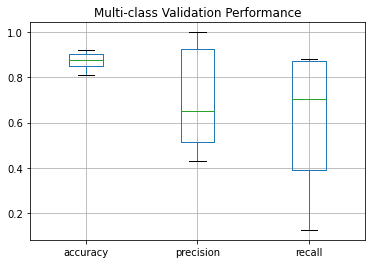

In [ ]:
df = pd.DataFrame(np.transpose(np.asarray(perf)), columns=['accuracy', 'precision', 'recall'])
df.boxplot(column=['accuracy', 'precision', 'recall'])
title_boxplot = 'Multi-class Validation Performance'
plt.title( title_boxplot )
plt.show()

In [ ]:
# Convenience function for testing predictions.
def predict(imgx_path, classifier, binary):

  # Display original image
  img = Image.open(imgx_path)
  plt.imshow(img)

  imgx = load_img(imgx_path, target_size = (250,250))
  imgx_arr = img_to_array(imgx)
  imgx_arr = np.expand_dims(imgx_arr, axis = 0)

  if (binary is True):
    result = float(str(classifier.predict(imgx_arr))[2])
  else:
    result = np.argmax(classifier.predict(imgx_arr))

  print(f'prediction: {multi_test_name_order[result]}')
  print(f'choices: {multi_test_name_order}')

1/1 [==============================] - 0s 66ms/step
prediction: George_W_Bush
choices: ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


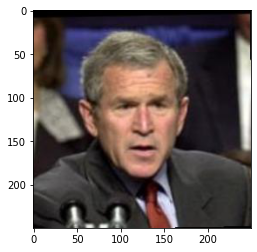

In [ ]:
test_img_path = basepath + 'George_W_Bush/George_W_Bush_0107.jpg'
predict(test_img_path, multi_classifier, False)

1/1 [==============================] - 0s 62ms/step
prediction: Ariel_Sharon
choices: ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


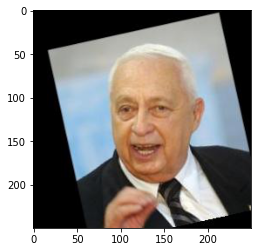

In [ ]:
test_img_path = basepath + 'Ariel_Sharon/Ariel_Sharon_0051.jpg'
predict(test_img_path, multi_classifier, False)

1/1 [==============================] - 0s 61ms/step
prediction: Gerhard_Schroeder
choices: ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


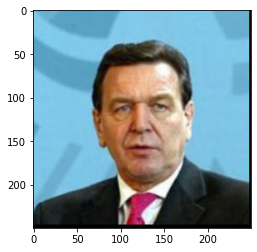

In [ ]:
test_img_path = basepath + 'Gerhard_Schroeder/Gerhard_Schroeder_0081.jpg'
predict(test_img_path, multi_classifier, False)

1/1 [==============================] - 0s 65ms/step
prediction: Tony_Blair
choices: ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


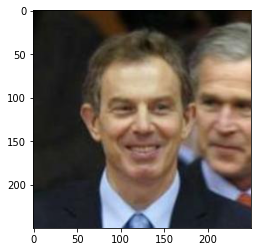

In [ ]:
test_img_path = basepath + 'Tony_Blair/Tony_Blair_0027.jpg'
predict(test_img_path, multi_classifier, False)

1/1 [==============================] - 0s 111ms/step
prediction: Colin_Powell
choices: ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


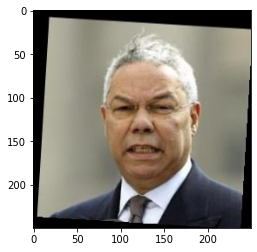

In [ ]:
test_img_path = basepath + 'Colin_Powell/Colin_Powell_0007.jpg'
predict(test_img_path, multi_classifier, False)

# Part 2: FaceNet with Nearest Neighbors

### Leveraging a pre-trained model (facenet_keras.h5).

In [ ]:
import os

import numpy as np
import cv2

from keras.models import load_model
from sklearn.neighbors import NearestNeighbors
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Upload facenet model and verify model existence

In [ ]:
# - Model input shape: [160, 160, 3]
# - Model output shape: [128]
SAVED_MODEL_PATH = dataset_path+'/facenet_keras.h5' #change it to your model position
assert os.path.exists(SAVED_MODEL_PATH)

EMB_DIM = 128

### FaceNet convenience class to load an image and predict facial embeddings.

In [ ]:
class FaceNet:
  def __init__(self):
    self.model = load_model(SAVED_MODEL_PATH, compile=False)

  def _load_image(self, image_path):
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (160, 160))
    image = image.astype('float') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

  def predict_embedding(self, image_path):
    image = self._load_image(image_path)
    return self.model.predict(image)[0]

### Face Recognition class - leverages FaceNet embedding predictions and applying Nearest Neighbors to arrive at labeled face predictions.

In [ ]:
class FaceRecognizer:
  def __init__(self, facenet):
    self.facenet = facenet
    self.nn = NearestNeighbors(n_neighbors=3, metric='l2', algorithm='brute')
    self.face_matrix = None
    self.face_index = None # index to label


  # Image file name will be used as label.
  # E.g. `elon_mask` will be the label for image  `/path/to/elon_mask.jpeg` 
  def build_face_database(self, image_paths):
    self.face_matrix = np.zeros([len(image_paths), EMB_DIM], dtype=float)
    self.face_index = [None] * len(image_paths)
    for i, fp in enumerate(image_paths):
      if not os.path.exists(fp):
        print(f'[Error] image {fp} does not exist.')
        return

      print(f'Processing image {fp}...')
      label = os.path.basename(fp).split('.')[0]
      emb = self.facenet.predict_embedding(fp)
      self.face_matrix[i, :] = emb
      self.face_index[i] = label
      print(f'Added image {fp} to database with label {label}.')

    print(f'Matrix shape: {self.face_matrix.shape}')
    self.nn.fit(self.face_matrix)


  # Return label and distance
  def recognize(self, image_path):
    if not os.path.exists(image_path):
        print(f'[Error] image {image_path} does not exist.')
        return
    emb = self.facenet.predict_embedding(image_path)
    emb = np.expand_dims(emb, axis=0)
    dists, inds = self.nn.kneighbors(emb)
    for i, d in zip(inds[0], dists[0]):
      print(f'{self.face_index[i]} -> {d}')
    label = self.face_index[inds[0][0]]
    return label, dists[0][0]

### Build a face database consisting of embedding and label pairs, based on inspection of a supplied directory containing a collection of images.

In [ ]:
facenet = FaceNet()
recognizer = FaceRecognizer(facenet)
recognizer.build_face_database(glob.glob(dataset_path+'/face_dataset/*')) # change this to your collection of images

Processing image /content/drive/My Drive/CMPE-258-Deep-Learning/lfw//face_dataset/mark_zuckerberg.jpeg...
1/1 [==============================] - 3s 3s/step
Added image /content/drive/My Drive/CMPE-258-Deep-Learning/lfw//face_dataset/mark_zuckerberg.jpeg to database with label mark_zuckerberg.
Processing image /content/drive/My Drive/CMPE-258-Deep-Learning/lfw//face_dataset/bill_gates.png...
1/1 [==============================] - 0s 177ms/step
Added image /content/drive/My Drive/CMPE-258-Deep-Learning/lfw//face_dataset/bill_gates.png to database with label bill_gates.
Processing image /content/drive/My Drive/CMPE-258-Deep-Learning/lfw//face_dataset/elon_mask.jpeg...
1/1 [==============================] - 0s 186ms/step
Added image /content/drive/My Drive/CMPE-258-Deep-Learning/lfw//face_dataset/elon_mask.jpeg to database with label elon_mask.
Processing image /content/drive/My Drive/CMPE-258-Deep-Learning/lfw//face_dataset/larry_page.jpeg...
1/1 [==============================] - 0s 105m

### Display the original images of persons to ingest.

Text(0.5, 1.0, 'Qiong')

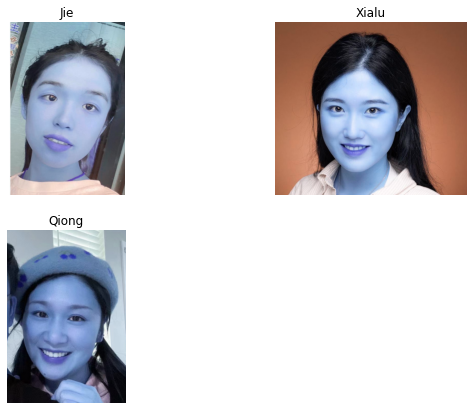

In [ ]:
#show the original pictures
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2
jie = cv2.imread(dataset_path+'face_dataset/xialu.jpg')
xialu  = cv2.imread(dataset_path+'face_dataset/jie.jpg')
qiong = cv2.imread(dataset_path+'face_dataset/qiong.png')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(jie)
plt.axis('off')
plt.title("Jie")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(xialu)
plt.axis('off')
plt.title("Xialu")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(qiong)
plt.axis('off')
plt.title("Qiong")

### Prediction Test #1

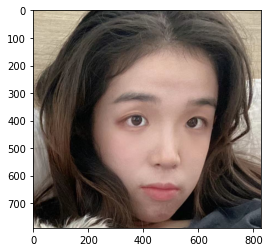

In [ ]:
query_image = dataset_path+'face_query_set/xialu1.jpg' # change this to the image need prediction
imgplot = plt.imshow(mpimg.imread(query_image))
plt.show()

Show Result of Prediction

In [ ]:
label, dist = recognizer.recognize(query_image)
print(f'This is {label}')

1/1 [==============================] - 0s 132ms/step
xialu -> 6.8405033332548495
Aaron_Sorkin -> 9.03702639343617
qiong -> 9.129283271206699
This is xialu


### Prediction Test #2

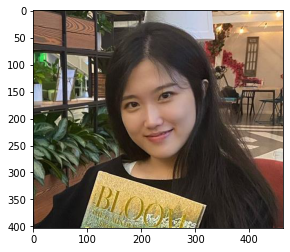

In [ ]:
query_image = dataset_path+'face_query_set/jie01.jpg' # change this to the image need prediction
imgplot = plt.imshow(mpimg.imread(query_image))
plt.show()

In [ ]:
label, dist = recognizer.recognize(query_image)
print(f'This is {label}')

1/1 [==============================] - 0s 102ms/step
jie -> 6.486737234091874
Aaron_Sorkin -> 6.804990263254738
xialu -> 9.990942305045001
This is jie


### Prediction Test #3

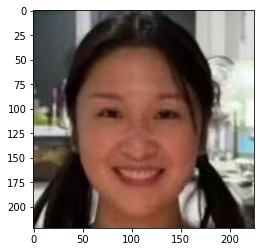

In [ ]:
query_image = dataset_path+'face_query_set/qiong1.jpg' # change this to the image need prediction
imgplot = plt.imshow(mpimg.imread(query_image))
plt.show()

In [ ]:
label, dist = recognizer.recognize(query_image)
print(f'This is {label}')

1/1 [==============================] - 0s 122ms/step
qiong -> 8.333457574164667
jie -> 9.108818370307345
xialu -> 10.679359370579391
This is qiong
